# Marketing campaign success estimation model

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text
import optuna
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [179]:
data = pd.read_csv(r'marketing.csv')
data

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,response,result
0,13829,29,technician,single,tertiary,no,18254,no,no,cellular,11,may,2,-1,0,unknown,no
1,22677,26,services,single,secondary,no,512,yes,yes,unknown,5,jun,3,-1,0,unknown,no
2,10541,30,management,single,secondary,no,135,no,no,cellular,14,aug,2,-1,0,unknown,no
3,13689,41,technician,married,unknown,no,30,yes,no,cellular,10,jul,1,-1,0,unknown,no
4,11304,27,admin.,single,secondary,no,321,no,yes,unknown,2,sep,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12865,14023,47,technician,married,secondary,no,1167,yes,no,cellular,30,apr,1,87,5,failure,yes
12866,17259,31,unknown,married,secondary,no,111,no,no,cellular,21,nov,2,93,2,failure,yes
12867,15200,37,unemployed,single,tertiary,no,1316,yes,no,cellular,18,nov,1,172,2,failure,no
12868,13775,42,management,married,tertiary,no,479,yes,no,unknown,28,may,2,-1,0,unknown,no


In [180]:
data.describe(include='all')

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,response,result
count,12870.000000,12870.000000,12870,12870,12870,12870,12870.000000,12870,12870,12870,12870.000000,12870,12870.000000,12870.000000,12870.000000,12870,12870
unique,NaN,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,4,2
top,NaN,NaN,management,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,unknown,no
freq,NaN,NaN,2858,7490,6368,12662,NaN,6605,11060,8756,NaN,3594,NaN,NaN,NaN,10070,8903
mean,16434.500000,41.091142,NaN,NaN,NaN,NaN,1483.774437,NaN,NaN,NaN,15.641103,NaN,2.659130,45.555478,0.688967,NaN,NaN
std,3715.393317,11.305560,NaN,NaN,NaN,NaN,3311.055181,NaN,NaN,NaN,8.368983,NaN,2.863507,104.449411,2.049696,NaN,NaN
min,10000.000000,18.000000,NaN,NaN,NaN,NaN,-6847.000000,NaN,NaN,NaN,1.000000,NaN,1.000000,-1.000000,0.000000,NaN,NaN
25%,13217.250000,32.000000,NaN,NaN,NaN,NaN,102.000000,NaN,NaN,NaN,8.000000,NaN,1.000000,-1.000000,0.000000,NaN,NaN
50%,16434.500000,39.000000,NaN,NaN,NaN,NaN,515.000000,NaN,NaN,NaN,16.000000,NaN,2.000000,-1.000000,0.000000,NaN,NaN
75%,19651.750000,49.000000,NaN,NaN,NaN,NaN,1591.750000,NaN,NaN,NaN,21.000000,NaN,3.000000,-1.000000,0.000000,NaN,NaN


In [181]:
for i in data.columns:
        print(data[i].value_counts())
        print()

ID
13829    1
19977    1
12484    1
12284    1
21301    1
        ..
13170    1
22371    1
20385    1
17987    1
20137    1
Name: count, Length: 12870, dtype: int64

age
32    569
33    565
31    545
34    533
36    526
     ... 
90      2
93      2
88      1
95      1
92      1
Name: count, Length: 76, dtype: int64

job
management       2858
blue-collar      2571
technician       2141
admin.           1464
services         1043
retired           770
self-employed     454
unemployed        414
entrepreneur      383
student           358
housemaid         334
unknown            80
Name: count, dtype: int64

marital
married     7490
single      3905
divorced    1475
Name: count, dtype: int64

education
secondary    6368
tertiary     4075
primary      1880
unknown       547
Name: count, dtype: int64

default
no     12662
yes      208
Name: count, dtype: int64

balance
 0        924
 1         52
 2         49
 4         40
 3         39
         ... 
 12705      1
-1148       1
-527      

In [182]:
data.drop(['ID', 'pdays', 'previous', 'default'], axis=1, inplace=True)

In [183]:
data['result'] = data['result'].map({'yes':0,'no':1})

In [184]:
data.isnull().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
response     0
result       0
dtype: int64

In [185]:
def age_group(age):
    if age < 25:
        return 'young'
    elif 25 <= age < 45:
        return 'adult'
    elif 45 <= age < 65:
        return 'middle'
    else:
        return 'senior'

data['age_group'] = data['age'].apply(age_group)
data

,age,job,marital,education,balance,housing,loan,contact,day,month,campaign,response,result,age_group
0,29,technician,single,tertiary,18254,no,no,cellular,11,may,2,unknown,1,adult
1,26,services,single,secondary,512,yes,yes,unknown,5,jun,3,unknown,1,adult
2,30,management,single,secondary,135,no,no,cellular,14,aug,2,unknown,1,adult
3,41,technician,married,unknown,30,yes,no,cellular,10,jul,1,unknown,1,adult
4,27,admin.,single,secondary,321,no,yes,unknown,2,sep,1,unknown,1,adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12865,47,technician,married,secondary,1167,yes,no,cellular,30,apr,1,failure,0,middle
12866,31,unknown,married,secondary,111,no,no,cellular,21,nov,2,failure,0,adult
12867,37,unemployed,single,tertiary,1316,yes,no,cellular,18,nov,1,failure,1,adult
12868,42,management,married,tertiary,479,yes,no,unknown,28,may,2,unknown,1,adult


In [186]:
def balance_rate(balance):
    if balance < 500:
        return 'low'
    elif balance < 2000:
        return 'medium'
    else:
        return 'high'

data['balance_rate'] = data['balance'].apply(balance_rate)
data

,age,job,marital,education,balance,housing,loan,contact,day,month,campaign,response,result,age_group,balance_rate
0,29,technician,single,tertiary,18254,no,no,cellular,11,may,2,unknown,1,adult,high
1,26,services,single,secondary,512,yes,yes,unknown,5,jun,3,unknown,1,adult,medium
2,30,management,single,secondary,135,no,no,cellular,14,aug,2,unknown,1,adult,low
3,41,technician,married,unknown,30,yes,no,cellular,10,jul,1,unknown,1,adult,low
4,27,admin.,single,secondary,321,no,yes,unknown,2,sep,1,unknown,1,adult,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12865,47,technician,married,secondary,1167,yes,no,cellular,30,apr,1,failure,0,middle,medium
12866,31,unknown,married,secondary,111,no,no,cellular,21,nov,2,failure,0,adult,low
12867,37,unemployed,single,tertiary,1316,yes,no,cellular,18,nov,1,failure,1,adult,medium
12868,42,management,married,tertiary,479,yes,no,unknown,28,may,2,unknown,1,adult,low


In [187]:
def is_high_risk(row):
    if row['loan'] == 'yes' or row['age'] < 25 or row['age'] > 65:
        return 1
    else:
        return 0

data['is_high_risk'] = data.apply(is_high_risk, axis=1)
data

,age,job,marital,education,balance,housing,loan,contact,day,month,campaign,response,result,age_group,balance_rate,is_high_risk
0,29,technician,single,tertiary,18254,no,no,cellular,11,may,2,unknown,1,adult,high,0
1,26,services,single,secondary,512,yes,yes,unknown,5,jun,3,unknown,1,adult,medium,1
2,30,management,single,secondary,135,no,no,cellular,14,aug,2,unknown,1,adult,low,0
3,41,technician,married,unknown,30,yes,no,cellular,10,jul,1,unknown,1,adult,low,0
4,27,admin.,single,secondary,321,no,yes,unknown,2,sep,1,unknown,1,adult,low,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12865,47,technician,married,secondary,1167,yes,no,cellular,30,apr,1,failure,0,middle,medium,0
12866,31,unknown,married,secondary,111,no,no,cellular,21,nov,2,failure,0,adult,low,0
12867,37,unemployed,single,tertiary,1316,yes,no,cellular,18,nov,1,failure,1,adult,medium,0
12868,42,management,married,tertiary,479,yes,no,unknown,28,may,2,unknown,1,adult,low,0


In [188]:
data_rf = data.copy()
data_knn = data.copy()

In [189]:
data_rf.dtypes

age              int64
job             object
marital         object
education       object
balance          int64
housing         object
loan            object
contact         object
day              int64
month           object
campaign         int64
response        object
result           int64
age_group       object
balance_rate    object
is_high_risk     int64
dtype: object

In [190]:
le = LabelEncoder()
label_cols = ['job', 'marital', 'contact', 'month', 'response']

for i in label_cols:
    data_rf[i] = le.fit_transform(data_rf[i])

data_rf

,age,job,marital,education,balance,housing,loan,contact,day,month,campaign,response,result,age_group,balance_rate,is_high_risk
0,29,9,2,tertiary,18254,no,no,0,11,8,2,3,1,adult,high,0
1,26,7,2,secondary,512,yes,yes,2,5,6,3,3,1,adult,medium,1
2,30,4,2,secondary,135,no,no,0,14,1,2,3,1,adult,low,0
3,41,9,1,unknown,30,yes,no,0,10,5,1,3,1,adult,low,0
4,27,0,2,secondary,321,no,yes,2,2,11,1,3,1,adult,low,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12865,47,9,1,secondary,1167,yes,no,0,30,0,1,0,0,middle,medium,0
12866,31,11,1,secondary,111,no,no,0,21,9,2,0,0,adult,low,0
12867,37,10,2,tertiary,1316,yes,no,0,18,9,1,0,1,adult,medium,0
12868,42,4,1,tertiary,479,yes,no,2,28,8,2,3,1,adult,low,0


In [191]:
data_rf['housing'] = data_rf['housing'].map({'yes':1,'no':0})
data_rf['loan'] = data_rf['loan'].map({'yes':1,'no':0})
data_rf['education'] = data_rf['education'].map({
    'unknown': 0,
    'primary': 1,
    'secondary': 2,
    'tertiary': 3
})
data_rf['age_group'] = data_rf['age_group'].map({
    'young': 1,
    'adult': 2,
    'middle': 3,
    'senior': 4
})
data_rf['balance_rate'] = data_rf['balance_rate'].map({
    'low': 0,
    'medium': 1,
    'high':2
})

data_rf

,age,job,marital,education,balance,housing,loan,contact,day,month,campaign,response,result,age_group,balance_rate,is_high_risk
0,29,9,2,3,18254,0,0,0,11,8,2,3,1,2,2,0
1,26,7,2,2,512,1,1,2,5,6,3,3,1,2,1,1
2,30,4,2,2,135,0,0,0,14,1,2,3,1,2,0,0
3,41,9,1,0,30,1,0,0,10,5,1,3,1,2,0,0
4,27,0,2,2,321,0,1,2,2,11,1,3,1,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12865,47,9,1,2,1167,1,0,0,30,0,1,0,0,3,1,0
12866,31,11,1,2,111,0,0,0,21,9,2,0,0,2,0,0
12867,37,10,2,3,1316,1,0,0,18,9,1,0,1,2,1,0
12868,42,4,1,3,479,1,0,2,28,8,2,3,1,2,0,0


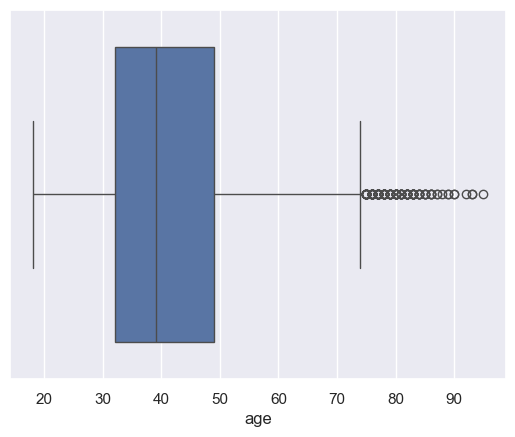

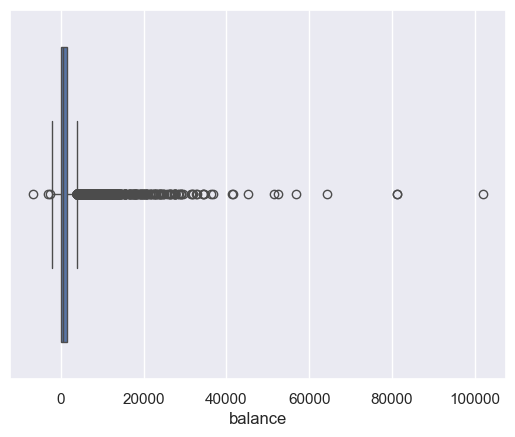

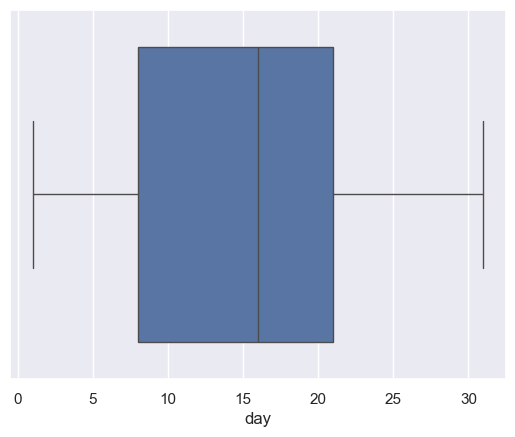

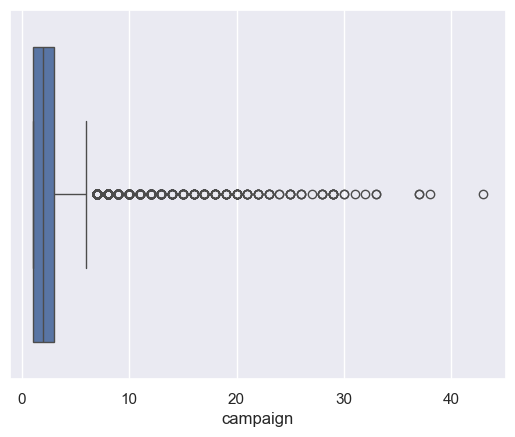

In [192]:
for i in data_knn.columns:
    if data_knn[i].dtypes!=object and len(data_knn[i].value_counts().index)>2:
        sns.boxplot(data=data_knn,x=data_knn[i])
        plt.show()

In [193]:
q1 = data_knn.quantile(0.25, numeric_only=True)
q3 = data_knn.quantile(0.75, numeric_only=True)
IQR = q3-q1

Lower = q1-1.5*IQR
Upper = q3+1.5*IQR

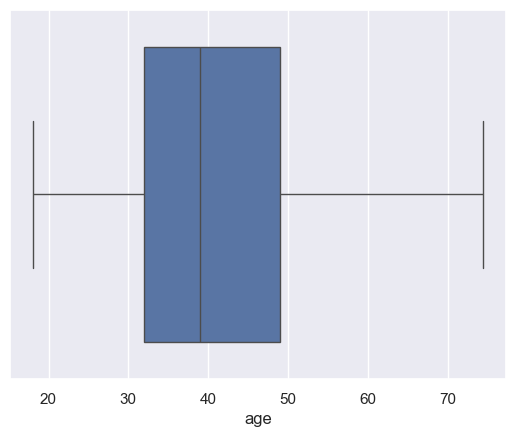

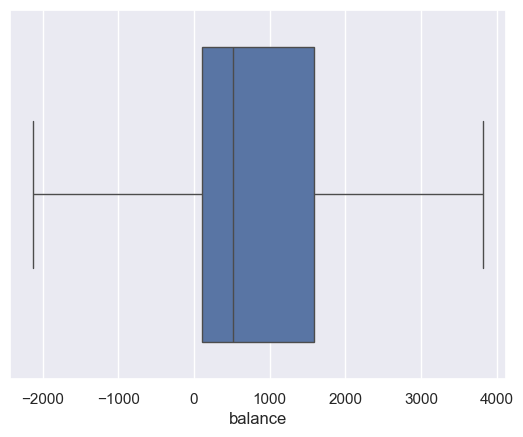

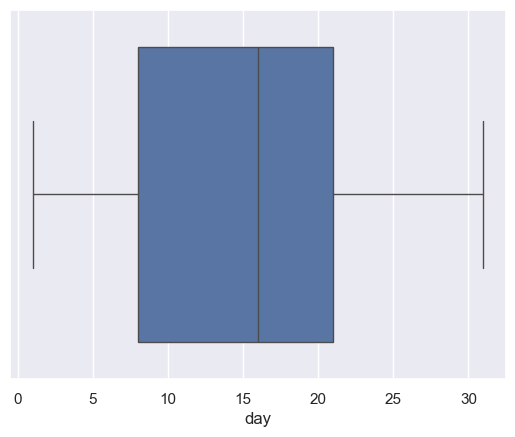

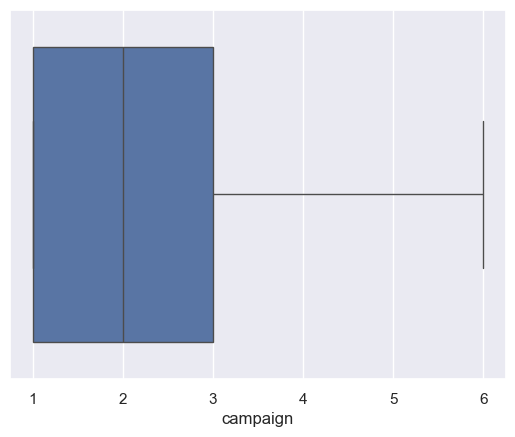

In [194]:
for i in data_knn.columns:
    if data_knn[i].dtypes!=object and len(data_knn[i].value_counts().index)>2:
        data_knn[i] = np.where(data_knn[i] > Upper[i],Upper[i],data_knn[i])
        data_knn[i] = np.where(data_knn[i] < Lower[i],Lower[i],data_knn[i])
        sns.boxplot(data=data_knn,x=data_knn[i])
        plt.show()

In [195]:
from scipy import stats

for i in data.columns:
    
    if data[i].dtype in ['int64', 'float64']:
        
        kstest_statistic, kstest_p_value = stats.kstest(data[i], 'norm')
        
        print(f'Column: {i}')
        print(f'p-value: {kstest_p_value}')
        
        if kstest_p_value > 0.05:
            print('Data looks normally distributed')
            print()
        else:
            print('Data does not look normally distributed')
            print()

Column: age
p-value: 0.0
Data does not look normally distributed

Column: balance
p-value: 0.0
Data does not look normally distributed

Column: day
p-value: 0.0
Data does not look normally distributed

Column: campaign
p-value: 0.0
Data does not look normally distributed

Column: result
p-value: 0.0
Data does not look normally distributed

Column: is_high_risk
p-value: 0.0
Data does not look normally distributed



In [196]:
def target_correlation(data, target, threshold=0.1):
    
    corr_matrix = data.corr(method='spearman', numeric_only=True)
    
    target_correlations = corr_matrix[target].abs() > threshold
    
    variables_explaining_target = target_correlations[target_correlations].index.tolist()

    variables_explaining_target.remove(target)
    
    result_explaining_target = pd.DataFrame(
    {'Variable': variables_explaining_target,
    'Correlation with Target': corr_matrix.loc[variables_explaining_target, target]})
    
    result_explaining_target.reset_index(drop=True, inplace=True)
    
    return result_explaining_target

target_result = target_correlation(data_knn, 'result')
target_result

,Variable,Correlation with Target
0,balance,-0.139456
1,campaign,0.121709


In [197]:
def intercorrelation(data, target, threshold=0.7):
    
    corr_matrix = data.corr(method='spearman', numeric_only=True)
    
    highly_correlated_variables = (np.abs(corr_matrix) > threshold) & (corr_matrix != 1.0)
    
    independent_variable_pairs = np.where(highly_correlated_variables)
    
    correlated_pairs_set = set()
   
    for var1, var2 in zip(independent_variable_pairs[0], independent_variable_pairs[1]):

        if var1 < var2:
            correlated_pairs_set.add((corr_matrix.index[var1], corr_matrix.columns[var2]))
        else:
            correlated_pairs_set.add((corr_matrix.index[var2], corr_matrix.columns[var1]))
    
    result_intercorrelated_independent = pd.DataFrame(list(correlated_pairs_set), columns=['Variable 1', 'Variable 2'])
    
    return result_intercorrelated_independent

intercorrelated_result = intercorrelation(data_knn, 'result')
intercorrelated_result

,Variable 1,Variable 2


In [198]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data_knn, variables):
    vif_data = data_knn[variables]
    vif_values = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
    vif_result = pd.DataFrame({'VIF': vif_values, 'Features': variables})
    return vif_result

vif_result = calculate_vif(data_knn, ['balance','campaign'])

vif_result

,VIF,Features
0,1.35372,balance
1,1.35372,campaign


In [199]:
data_knn = pd.get_dummies(data_knn, drop_first=True, dtype=int)
data_knn

,age,balance,day,campaign,result,is_high_risk,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_oct,month_sep,response_other,response_success,response_unknown,age_group_middle,age_group_senior,age_group_young,balance_rate_low,balance_rate_medium
0,29.0,3826.375,11.0,2.0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,26.0,512.000,5.0,3.0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,30.0,135.000,14.0,2.0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
3,41.0,30.000,10.0,1.0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,27.0,321.000,2.0,1.0,1,1,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12865,47.0,1167.000,30.0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
12866,31.0,111.000,21.0,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12867,37.0,1316.000,18.0,1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12868,42.0,479.000,28.0,2.0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0


In [200]:
target_result.Variable.tolist()

['balance', 'campaign']

In [201]:
data_knn.columns

Index(['age', 'balance', 'day', 'campaign', 'result', 'is_high_risk',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'housing_yes', 'loan_yes',
       'contact_telephone', 'contact_unknown', 'month_aug', 'month_dec',
       'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep', 'response_other',
       'response_success', 'response_unknown', 'age_group_middle',
       'age_group_senior', 'age_group_young', 'balance_rate_low',
       'balance_rate_medium'],
      dtype='object')

In [202]:
inputs_rf = data_rf.drop(columns=['result'])
inputs_knn = data_knn[['balance', 'campaign', 'is_high_risk',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'housing_yes', 'loan_yes',
       'contact_telephone', 'contact_unknown', 'month_aug', 'month_dec',
       'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep', 'response_other',
       'response_success', 'response_unknown', 'age_group_middle',
       'age_group_senior', 'age_group_young', 'balance_rate_low',
       'balance_rate_medium']]
output = data['result']

In [203]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(inputs_knn)

StandardScaler()

In [204]:
inputs_scaled = scaler.transform(inputs_knn)

data_scaled_knn = pd.DataFrame(inputs_scaled, columns=inputs_knn.columns)

data_scaled_knn

,balance,campaign,is_high_risk,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,month_oct,month_sep,response_other,response_success,response_unknown,age_group_middle,age_group_senior,age_group_young,balance_rate_low,balance_rate_medium
0,2.167727,-0.212008,-0.479511,-0.499636,-0.175134,-0.163228,-0.534282,-0.252262,-0.191222,-0.296965,...,-0.164228,-0.147489,-0.216257,-0.265085,0.527308,-0.685578,-0.172286,-0.150216,-0.985957,-0.657077
1,-0.416166,0.423719,2.085456,-0.499636,-0.175134,-0.163228,-0.534282,-0.252262,-0.191222,3.367403,...,-0.164228,-0.147489,-0.216257,-0.265085,0.527308,-0.685578,-0.172286,-0.150216,-0.985957,1.521892
2,-0.710076,-0.212008,-0.479511,-0.499636,-0.175134,-0.163228,1.871670,-0.252262,-0.191222,-0.296965,...,-0.164228,-0.147489,-0.216257,-0.265085,0.527308,-0.685578,-0.172286,-0.150216,1.014243,-0.657077
3,-0.791935,-0.847735,-0.479511,-0.499636,-0.175134,-0.163228,-0.534282,-0.252262,-0.191222,-0.296965,...,-0.164228,-0.147489,-0.216257,-0.265085,0.527308,-0.685578,-0.172286,-0.150216,1.014243,-0.657077
4,-0.565070,-0.847735,2.085456,-0.499636,-0.175134,-0.163228,-0.534282,-0.252262,-0.191222,-0.296965,...,-0.164228,6.780177,-0.216257,-0.265085,0.527308,-0.685578,-0.172286,-0.150216,1.014243,-0.657077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12865,0.094473,-0.847735,-0.479511,-0.499636,-0.175134,-0.163228,-0.534282,-0.252262,-0.191222,-0.296965,...,-0.164228,-0.147489,-0.216257,-0.265085,-1.896425,1.458623,-0.172286,-0.150216,-0.985957,1.521892
12866,-0.728787,-0.212008,-0.479511,-0.499636,-0.175134,-0.163228,-0.534282,-0.252262,-0.191222,-0.296965,...,-0.164228,-0.147489,-0.216257,-0.265085,-1.896425,-0.685578,-0.172286,-0.150216,1.014243,-0.657077
12867,0.210634,-0.847735,-0.479511,-0.499636,-0.175134,-0.163228,-0.534282,-0.252262,-0.191222,-0.296965,...,-0.164228,-0.147489,-0.216257,-0.265085,-1.896425,-0.685578,-0.172286,-0.150216,-0.985957,1.521892
12868,-0.441893,-0.212008,-0.479511,-0.499636,-0.175134,-0.163228,1.871670,-0.252262,-0.191222,-0.296965,...,-0.164228,-0.147489,-0.216257,-0.265085,0.527308,-0.685578,-0.172286,-0.150216,1.014243,-0.657077


In [205]:
X_train_rf,  X_test_rf,  y_train, y_test = train_test_split(inputs_rf, output, test_size=0.3, random_state=42)
X_train_knn, X_test_knn, y_train, y_test = train_test_split(data_scaled_knn, output, test_size = 0.3, random_state = 42)

In [206]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

def evaluate(model, X_train_rf, y_train, X_test_rf, y_test):
    
    '''Predictions and probabilities for the training set'''
    
    y_train_pred = model.predict(X_train_rf)
    y_train_prob = model.predict_proba(X_train_rf)[:, 1]

    '''Predictions and probabilities for the test set'''
    
    y_test_pred = model.predict(X_test_rf)
    y_test_prob = model.predict_proba(X_test_rf)[:, 1]

    '''Calculate metrics for the training set''' 
    
    roc_train_prob = roc_auc_score(y_train, y_train_prob)
    gini_train_prob = roc_train_prob * 2 - 1
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)

    '''Calculate metrics for the test set'''
    
    roc_test_prob = roc_auc_score(y_test, y_test_prob)
    gini_test_prob = roc_test_prob * 2 - 1
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)

    results = pd.DataFrame({
        'Dataset': ['Train', 'Test'],
        'Gini': [gini_train_prob * 100, gini_test_prob * 100],
        'Precision': [precision_train, precision_test],
        'Recall': [recall_train, recall_test]
    })

    confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    
    return results , confusion_matrix

In [207]:
rfc = RandomForestClassifier(n_estimators=100,random_state=42)
rfc.fit(X_train_rf, y_train)

RandomForestClassifier(random_state=42)

In [208]:
result = evaluate(rfc, X_train_rf, y_train, X_test_rf, y_test)
result

(  Dataset      Gini  Precision    Recall
 0   Train  100.0000   1.000000  1.000000
 1    Test   53.0106   0.798964  0.915091,
 array([[ 543,  621],
        [ 229, 2468]], dtype=int64))

In [209]:
def plot_feature_importances(model, feature_names):
    
    importances = model.feature_importances_
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by="Importance", ascending=False)
   
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.title("Feature Importances")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.gca().invert_yaxis() 
    plt.show()
    
    return importance_df

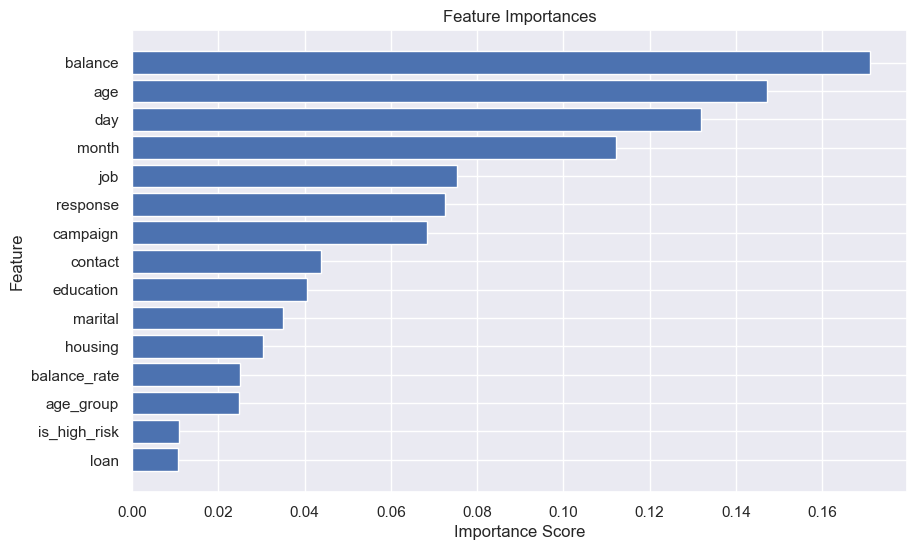

,Feature,Importance
4,balance,0.171169
0,age,0.147250
8,day,0.131856
9,month,0.112306
1,job,0.075348
11,response,0.072549
10,campaign,0.068412
7,contact,0.043747
3,education,0.040587
2,marital,0.035101


In [210]:
feature_names = X_train_rf.columns

feature_importance_df = plot_feature_importances(rfc, feature_names)

feature_importance_df

In [211]:
selected_features = feature_importance_df[
    (feature_importance_df['Importance'] > 0.05) &
    (feature_importance_df['Importance'] < 0.35)
]['Feature'].tolist()

In [212]:
clfRF_selected = RandomForestClassifier(random_state=42)
clfRF_selected.fit(X_train_rf[selected_features], y_train)

RandomForestClassifier(random_state=42)

In [213]:

result = evaluate(
    clfRF_selected,
    X_train_rf[selected_features], y_train,
    X_test_rf[selected_features], y_test
)

result


(  Dataset        Gini  Precision    Recall
 0   Train  100.000000   1.000000  1.000000
 1    Test   46.894698   0.788209  0.912125,
 array([[ 503,  661],
        [ 237, 2460]], dtype=int64))

In [214]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    n_estimators = trial.suggest_categorical('n_estimators', [int(x) for x in np.linspace(200, 1000, 10)])
    max_depth = trial.suggest_categorical('max_depth', [int(x) for x in np.linspace(10, 100, 11)])
    max_features = trial.suggest_categorical('max_features', ['sqrt', 0.3, 0.5, None])
    min_samples_split = trial.suggest_categorical('min_samples_split', [20, 50])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [5, 8, 10])
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
    
    return cross_val_score(model, X_train_rf, y_train, cv=3, scoring='accuracy').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

print("Optuna best parameters:", study.best_params)

optimized_model_optuna = RandomForestClassifier(**study.best_params, random_state=42, n_jobs=-1)
optimized_model_optuna.fit(X_train_rf, y_train)


[I 2025-10-12 20:31:08,301] A new study created in memory with name: no-name-077c2f18-4ffd-45fc-b6bf-40ee8bbc9378
[I 2025-10-12 20:31:13,295] Trial 0 finished with value: 0.7734487734487735 and parameters: {'n_estimators': 644, 'max_depth': 55, 'max_features': 0.3, 'min_samples_split': 20, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7734487734487735.
[I 2025-10-12 20:31:17,152] Trial 1 finished with value: 0.7766677766677766 and parameters: {'n_estimators': 555, 'max_depth': 19, 'max_features': 0.5, 'min_samples_split': 50, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.7766677766677766.
[I 2025-10-12 20:31:18,555] Trial 2 finished with value: 0.7778887778887779 and parameters: {'n_estimators': 200, 'max_depth': 100, 'max_features': 0.5, 'min_samples_split': 50, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.7778887778887779.
[I 2025-10-12 20:31:24,215] Trial 3 finished with value: 0.7742257742257742 and parameters: {'n_estimators': 822, 'max_depth': 55, 'max_f

Optuna best parameters: {'n_estimators': 200, 'max_depth': 100, 'max_features': 0.5, 'min_samples_split': 50, 'min_samples_leaf': 10}


RandomForestClassifier(max_depth=100, max_features=0.5, min_samples_leaf=10,
                       min_samples_split=50, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [215]:
evaluate(optimized_model_optuna, X_train_rf, y_train, X_test_rf, y_test)

(  Dataset       Gini  Precision    Recall
 0   Train  74.903161   0.806263  0.933451
 1    Test  54.527049   0.796761  0.930293,
 array([[ 524,  640],
        [ 188, 2509]], dtype=int64))

# KNN

In [216]:
classifier = KNeighborsClassifier()
classifier.fit(X_train_knn, y_train)

KNeighborsClassifier()

In [217]:
evaluate(classifier,X_train_knn, y_train, X_test_knn, y_test)

(  Dataset       Gini  Precision    Recall
 0   Train  73.977343   0.825514  0.918627
 1    Test  41.192072   0.779655  0.872451,
 array([[ 499,  665],
        [ 344, 2353]], dtype=int64))

In [218]:
from sklearn.model_selection import cross_val_score
import optuna

def best_params_for_model(trial):
    param = {
    'n_neighbors': trial.suggest_int('n_neighbors', 3, 30), 
    'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),  
    'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),  
    'leaf_size': trial.suggest_int('leaf_size', 10, 100),  
    'p': trial.suggest_int('p', 1, 2),  
    'metric': trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan']) 
}

    knn_clf = KNeighborsClassifier(**param)

    roc = cross_val_score(knn_clf, X_train_knn, y_train, cv=5, scoring='roc_auc', n_jobs=-1).mean()
    return roc

study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=50)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_knn_model = KNeighborsClassifier(**best_params)

[I 2025-10-12 20:32:30,974] A new study created in memory with name: no-name-89e65993-4955-441f-93f6-3118012bec52
[I 2025-10-12 20:32:34,891] Trial 0 finished with value: 0.7330152804377452 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 72, 'p': 1, 'metric': 'minkowski'}. Best is trial 0 with value: 0.7330152804377452.
[I 2025-10-12 20:32:37,038] Trial 1 finished with value: 0.7338884040791612 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 90, 'p': 1, 'metric': 'minkowski'}. Best is trial 1 with value: 0.7338884040791612.
[I 2025-10-12 20:32:38,691] Trial 2 finished with value: 0.7272649870189367 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 80, 'p': 2, 'metric': 'manhattan'}. Best is trial 1 with value: 0.7338884040791612.
[I 2025-10-12 20:32:39,757] Trial 3 finished with value: 0.7375641593333129 and parameters: {'n_neighbors': 13, 'weights': 'u

Best trial:
  Value: 0.750
  Params:  {'n_neighbors': 30, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 34, 'p': 2, 'metric': 'manhattan'}


In [221]:
bkm = best_knn_model.fit(X_train_knn, y_train)

In [222]:
evaluate(bkm,X_train_knn, y_train, X_test_knn, y_test)

(  Dataset       Gini  Precision    Recall
 0   Train  59.127013   0.782503  0.933935
 1    Test  48.405859   0.779081  0.936225,
 array([[ 448,  716],
        [ 172, 2525]], dtype=int64))

# Deployment

In [224]:
data1 = pd.read_excel(r'marketing_test.xlsx')
data1.head(5)

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,response
0,812,25,blue-collar,single,secondary,no,764,yes,no,cellular,18,may,1,-1,0,unknown
1,71,40,blue-collar,single,primary,no,118,no,no,unknown,23,feb,1,-1,0,unknown
2,912,27,admin.,divorced,secondary,no,451,yes,no,cellular,16,jul,1,-1,0,unknown
3,43,30,services,single,secondary,no,495,yes,no,cellular,21,nov,1,-1,0,unknown
4,431,36,blue-collar,married,primary,no,1548,yes,yes,cellular,18,may,2,-1,0,unknown


In [225]:
X_train_knn.columns

Index(['balance', 'campaign', 'is_high_risk', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'housing_yes', 'loan_yes', 'contact_telephone', 'contact_unknown',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'response_other', 'response_success', 'response_unknown',
       'age_group_middle', 'age_group_senior', 'age_group_young',
       'balance_rate_low', 'balance_rate_medium'],
      dtype='object')

In [226]:
data1.drop(['pdays', 'previous', 'default'], axis=1, inplace=True)
data1

,ID,age,job,marital,education,balance,housing,loan,contact,day,month,campaign,response
0,812,25,blue-collar,single,secondary,764,yes,no,cellular,18,may,1,unknown
1,71,40,blue-collar,single,primary,118,no,no,unknown,23,feb,1,unknown
2,912,27,admin.,divorced,secondary,451,yes,no,cellular,16,jul,1,unknown
3,43,30,services,single,secondary,495,yes,no,cellular,21,nov,1,unknown
4,431,36,blue-collar,married,primary,1548,yes,yes,cellular,18,may,2,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,49,43,blue-collar,married,secondary,413,yes,no,cellular,12,aug,2,success
853,409,56,management,married,tertiary,1282,no,no,cellular,19,aug,4,unknown
854,105,54,admin.,married,primary,976,yes,no,unknown,3,jun,3,unknown
855,810,30,unemployed,single,tertiary,1159,no,no,telephone,5,jun,1,unknown


In [227]:
def age_group(age):
    if age < 25:
        return 'young'
    elif 25 <= age < 45:
        return 'adult'
    elif 45 <= age < 65:
        return 'middle'
    else:
        return 'senior'

data1['age_group'] = data1['age'].apply(age_group)
data1

,ID,age,job,marital,education,balance,housing,loan,contact,day,month,campaign,response,age_group
0,812,25,blue-collar,single,secondary,764,yes,no,cellular,18,may,1,unknown,adult
1,71,40,blue-collar,single,primary,118,no,no,unknown,23,feb,1,unknown,adult
2,912,27,admin.,divorced,secondary,451,yes,no,cellular,16,jul,1,unknown,adult
3,43,30,services,single,secondary,495,yes,no,cellular,21,nov,1,unknown,adult
4,431,36,blue-collar,married,primary,1548,yes,yes,cellular,18,may,2,unknown,adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,49,43,blue-collar,married,secondary,413,yes,no,cellular,12,aug,2,success,adult
853,409,56,management,married,tertiary,1282,no,no,cellular,19,aug,4,unknown,middle
854,105,54,admin.,married,primary,976,yes,no,unknown,3,jun,3,unknown,middle
855,810,30,unemployed,single,tertiary,1159,no,no,telephone,5,jun,1,unknown,adult


In [228]:
def balance_rate(balance):
    if balance < 500:
        return 'low'
    elif balance < 2000:
        return 'medium'
    else:
        return 'high'

data1['balance_rate'] = data1['balance'].apply(balance_rate)
data1

,ID,age,job,marital,education,balance,housing,loan,contact,day,month,campaign,response,age_group,balance_rate
0,812,25,blue-collar,single,secondary,764,yes,no,cellular,18,may,1,unknown,adult,medium
1,71,40,blue-collar,single,primary,118,no,no,unknown,23,feb,1,unknown,adult,low
2,912,27,admin.,divorced,secondary,451,yes,no,cellular,16,jul,1,unknown,adult,low
3,43,30,services,single,secondary,495,yes,no,cellular,21,nov,1,unknown,adult,low
4,431,36,blue-collar,married,primary,1548,yes,yes,cellular,18,may,2,unknown,adult,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,49,43,blue-collar,married,secondary,413,yes,no,cellular,12,aug,2,success,adult,low
853,409,56,management,married,tertiary,1282,no,no,cellular,19,aug,4,unknown,middle,medium
854,105,54,admin.,married,primary,976,yes,no,unknown,3,jun,3,unknown,middle,medium
855,810,30,unemployed,single,tertiary,1159,no,no,telephone,5,jun,1,unknown,adult,medium


In [229]:
def is_high_risk(row):
    if row['loan'] == 'yes' or row['age'] < 25 or row['age'] > 65:
        return 1
    else:
        return 0

data1['is_high_risk'] = data1.apply(is_high_risk, axis=1)
data1

,ID,age,job,marital,education,balance,housing,loan,contact,day,month,campaign,response,age_group,balance_rate,is_high_risk
0,812,25,blue-collar,single,secondary,764,yes,no,cellular,18,may,1,unknown,adult,medium,0
1,71,40,blue-collar,single,primary,118,no,no,unknown,23,feb,1,unknown,adult,low,0
2,912,27,admin.,divorced,secondary,451,yes,no,cellular,16,jul,1,unknown,adult,low,0
3,43,30,services,single,secondary,495,yes,no,cellular,21,nov,1,unknown,adult,low,0
4,431,36,blue-collar,married,primary,1548,yes,yes,cellular,18,may,2,unknown,adult,medium,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,49,43,blue-collar,married,secondary,413,yes,no,cellular,12,aug,2,success,adult,low,0
853,409,56,management,married,tertiary,1282,no,no,cellular,19,aug,4,unknown,middle,medium,0
854,105,54,admin.,married,primary,976,yes,no,unknown,3,jun,3,unknown,middle,medium,0
855,810,30,unemployed,single,tertiary,1159,no,no,telephone,5,jun,1,unknown,adult,medium,0


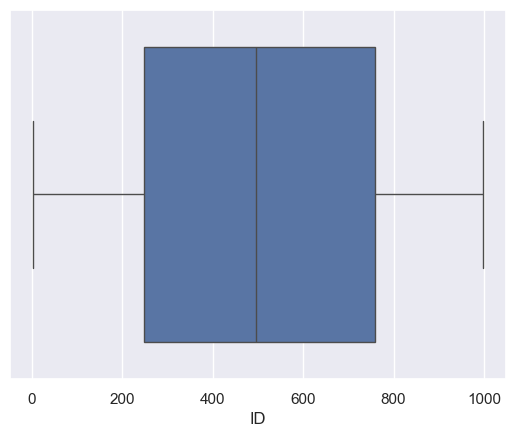

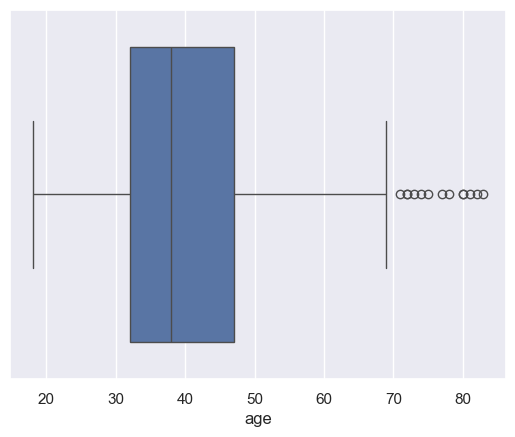

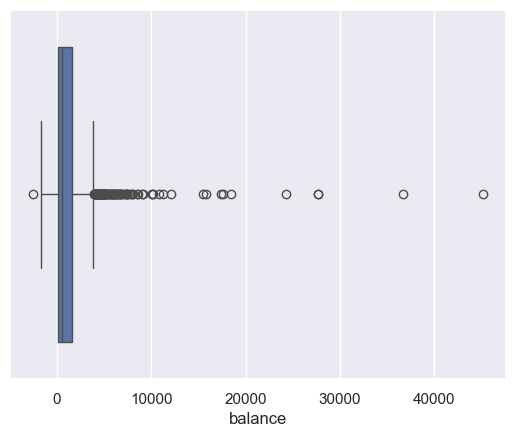

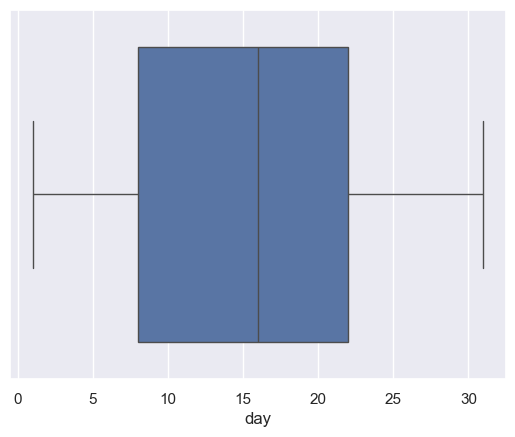

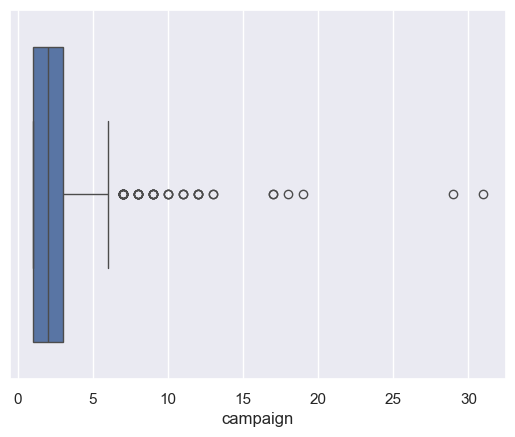

In [230]:
for i in data1.columns:
    if data1[i].dtypes!=object and len(data1[i].value_counts().index)>2:
        sns.boxplot(data=data1,x=data1[i])
        plt.show()

In [231]:
q1 = data1.quantile(0.25, numeric_only=True)
q3 = data1.quantile(0.75, numeric_only=True)
IQR = q3-q1

Lower = q1-1.5*IQR
Upper = q3+1.5*IQR

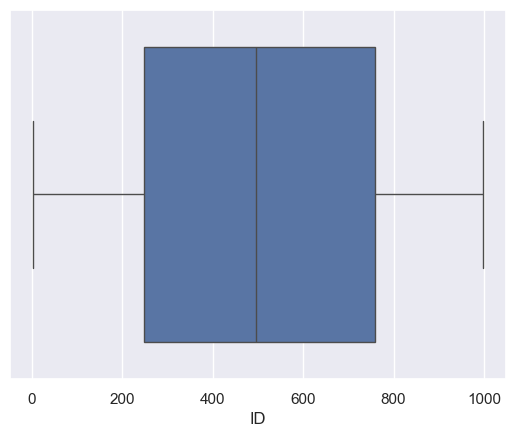

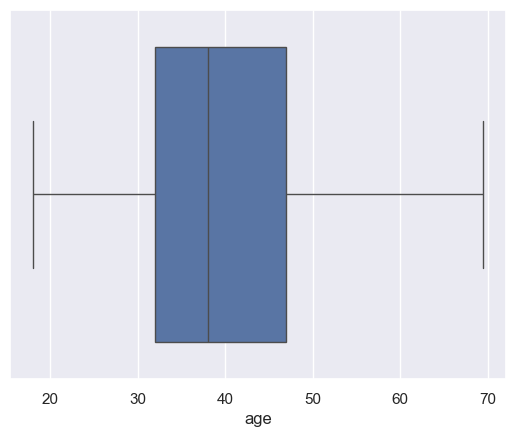

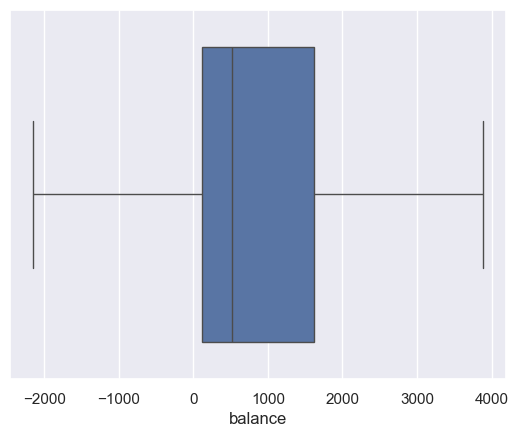

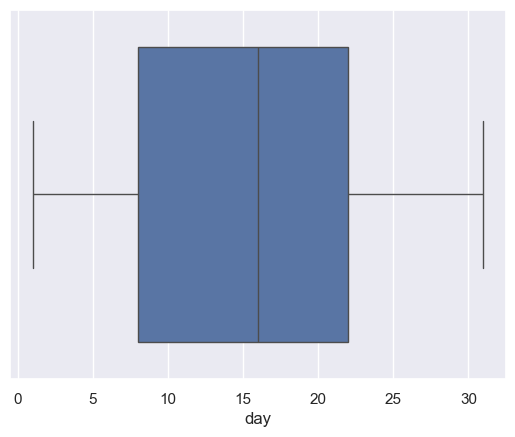

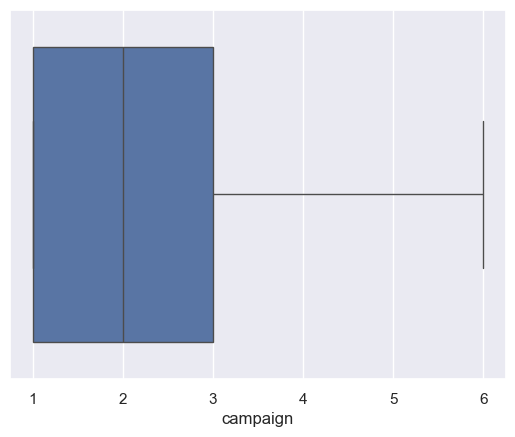

In [232]:
for i in data1.columns:
    if data1[i].dtypes!=object and len(data1[i].value_counts().index)>2:
        data1[i] = np.where(data1[i] > Upper[i],Upper[i],data1[i])
        data1[i] = np.where(data1[i] < Lower[i],Lower[i],data1[i])
        sns.boxplot(data=data1,x=data1[i])
        plt.show()

In [233]:
data1 = pd.get_dummies(data1, drop_first=True, dtype=int)
data1

,ID,age,balance,day,campaign,is_high_risk,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_oct,month_sep,response_other,response_success,response_unknown,age_group_middle,age_group_senior,age_group_young,balance_rate_low,balance_rate_medium
0,812.0,25.0,764.0,18.0,1.0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,71.0,40.0,118.0,23.0,1.0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,912.0,27.0,451.0,16.0,1.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,43.0,30.0,495.0,21.0,1.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,431.0,36.0,1548.0,18.0,2.0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,49.0,43.0,413.0,12.0,2.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
853,409.0,56.0,1282.0,19.0,4.0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,1
854,105.0,54.0,976.0,3.0,3.0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,1
855,810.0,30.0,1159.0,5.0,1.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [234]:
X_train_knn.columns

Index(['balance', 'campaign', 'is_high_risk', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'housing_yes', 'loan_yes', 'contact_telephone', 'contact_unknown',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'response_other', 'response_success', 'response_unknown',
       'age_group_middle', 'age_group_senior', 'age_group_young',
       'balance_rate_low', 'balance_rate_medium'],
      dtype='object')

In [235]:
data1 = data1[['ID', 'balance', 'campaign', 'is_high_risk', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'housing_yes', 'loan_yes', 'contact_telephone', 'contact_unknown',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'response_other', 'response_success', 'response_unknown',
       'age_group_middle', 'age_group_senior', 'age_group_young',
       'balance_rate_low', 'balance_rate_medium']]

In [236]:
data1['probability'] = bkm.predict_proba(data1.iloc[:,1:])[:,1]

data1

C:\Users\user\AppData\Local\Temp\ipykernel_3028\3392835741.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['probability'] = bkm.predict_proba(data1.iloc[:,1:])[:,1]


,ID,balance,campaign,is_high_risk,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,month_sep,response_other,response_success,response_unknown,age_group_middle,age_group_senior,age_group_young,balance_rate_low,balance_rate_medium,probability
0,812.0,764.0,1.0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0.733333
1,71.0,118.0,1.0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0.833333
2,912.0,451.0,1.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0.900000
3,43.0,495.0,1.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0.866667
4,431.0,1548.0,2.0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,49.0,413.0,2.0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0.866667
853,409.0,1282.0,4.0,0,0,0,0,1,0,0,...,0,0,0,1,1,0,0,0,1,0.700000
854,105.0,976.0,3.0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0.966667
855,810.0,1159.0,1.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0.500000
